# tidal harmonics analysis

with utide library, see their [github repository](https://github.com/wesleybowman/UTide/blob/master/README.md)

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

from utide import solve, reconstruct

/Users/aponte/.miniconda3/envs/insitu/lib/python3.10/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/Users/aponte/.miniconda3/envs/insitu/lib/python3.10/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


---

## load and inspect data from the Toulon tide gauge

In [6]:
# load data
# https://data.shom.fr/donnees/refmar/68/download

nc = "/Users/aponte/Current_Projects/das/data/2023/maregraphie/68_2023.nc"
ds = xr.open_dataset(nc)
# rename fields for convenience:
ds = ds.rename(
    TIME="time",
    LATITUDE="latitude",
    LONGITUDE="longitude",
    Source4="sea level",
)
ds

<xarray.Dataset> Size: 71kB
Dimensions:    (time: 5880)
Coordinates:
  * time       (time) datetime64[ns] 47kB 2023-04-01 ... 2023-12-01T23:00:00
Data variables:
    latitude   float32 4B ...
    longitude  float32 4B ...
    sea level  (time) float32 24kB ...
Attributes:
    title:           TOULON
    subtitle:        68
    description:     Dataset containing observation groups for sources: [4]
    history:         Created 27/10/24
    conventions:     CF-1.7
    time_system:     UTC
    netcdf_version:  netCDF-4 classic model
    institution:     Shom
    contact:         refmar@shom.fr
    references:      https://data.shom.fr/donnees/refmar/68

Visual inspection of the time series:

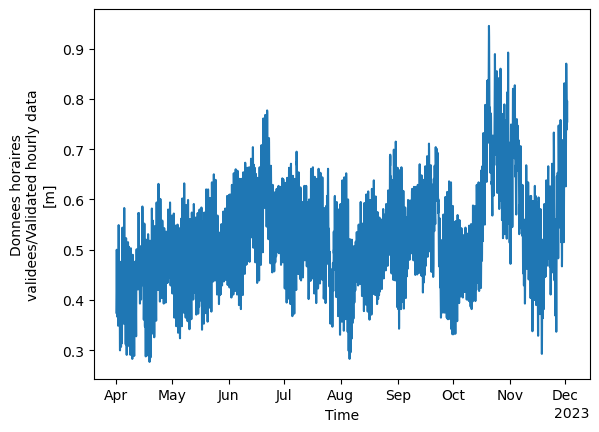

In [7]:
ds["sea level"].plot()

There is quite a bit of low frequency variability which has likely nothing to do with tides and is more likely to be related to: ocean low frequency circulation, expansion under heating/cooling, wind and atmospheric pressure fluctuations.
To mitigate the impact of this variability on the tidal harmonic analysis we high-pass filter the signal with a 2 days running mean (rather crude).

In [36]:
T = 2 # length of the running mean in days
dt = float(ds.time.diff("time").median()/np.timedelta64(1, 'D')) # sampling - should be hourly
print(f"Sampling is {dt*24:.1f} hours")
# apply rolling mean
ds["sea level low"] = ds["sea level"].rolling(time=int(T/dt), center=True).mean()
ds["sea level high"] = ds["sea level"] - ds["sea level low"]

Sampling is 1.0 hours


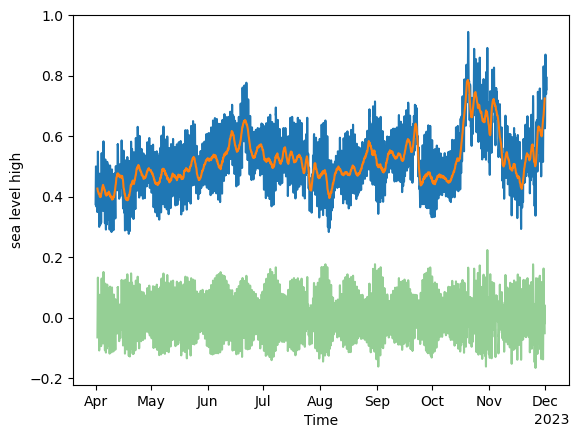

In [37]:
ds["sea level"].plot()
ds["sea level low"].plot()
ds["sea level high"].plot(alpha=.5)

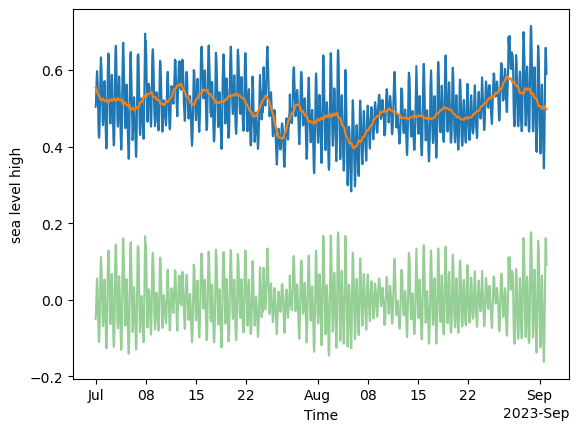

In [38]:
# zoom around a period of strong sea level fluctuations
_ds = ds.sel(time=slice("2023/07/01", "2023/09/01"))

_ds["sea level"].plot()
_ds["sea level low"].plot()
_ds["sea level high"].plot(alpha=.5)

---

## harmonic analysis of the full time series

In [42]:
# utils
def solve_and_predict(z, time, lat, dev=False, **kwargs):
    """ solve for tidal harmonics and create a tidal prediction
    """

    coef = solve(time, z, lat=lat)
    tide = reconstruct(time, coef, verbose=False)

    if dev:
        return coef, tide

    ha = _coef_to_xr(coef)
    
    pr = xr.Dataset(
        dict(
            z_in=("time", z),
            z_out=("time", tide["h"]),
        ),
        coords=dict(time=time),
    )
    tide["h"]
    
    return ha, pr 

def _coef_to_xr(coef):
    omega = coef["aux"]["frq"] # cph
    ds = xr.Dataset(
        dict(
            A=("constituent", coef["A"]),
            A_ci=("constituent", coef["A_ci"]),
            g=("constituent", coef["g"]),
            g_ci=("constituent", coef["g_ci"]),
            SNR=("constituent", coef["SNR"]),
        ),
        coords=dict(
            constituent=coef["name"],
            omega_cph=("constituent", omega),
            omega_cpd=("constituent", omega*24),
            omega=("constituent", 2*np.pi*omega/3600),
        ),
    )
    return ds

In [43]:
ha, pr = solve_and_predict(
    ds["sea level high"].values, 
    ds.time.values, 
    float(ds.latitude),
)

solve: matrix prep ... solution ... done.


Inspect harmonic constants:

In [59]:
df = ha[["A", "g", "SNR"]].to_dataframe()
df.iloc[:10]

,A,g,SNR,omega_cph,omega_cpd,omega
constituent,,,,,,
M2,0.072058,219.005077,196877.060929,0.080511,1.932274,0.000141
K1,0.032868,171.760960,7434.633890,0.041781,1.002738,0.000073
S2,0.026003,237.394149,25637.032344,0.083333,2.000000,0.000145
O1,0.018761,102.884852,2423.110076,0.038731,0.929536,0.000068
N2,0.014617,209.264171,8100.191191,0.078999,1.895982,0.000138
P1,0.009487,170.268620,619.529350,0.041553,0.997262,0.000073
K2,0.007508,233.753325,2137.291627,0.083561,2.005476,0.000146
M4,0.006296,345.409945,2404.373043,0.161023,3.864547,0.000281
MS4,0.004406,44.402721,1177.408531,0.163845,3.932274,0.000286


<Axes: xlabel='constituent'>

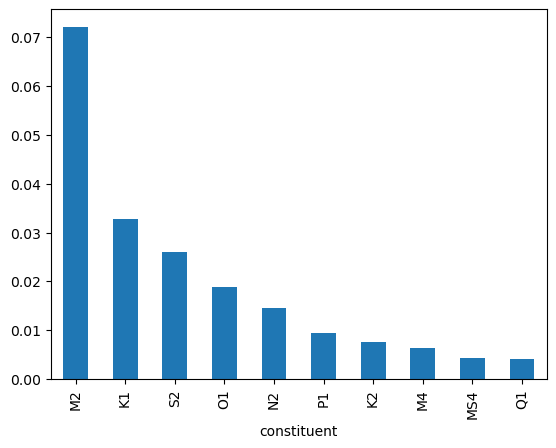

In [61]:
df["A"].iloc[:10].plot.bar()

SNRs are good for all dominant constituants

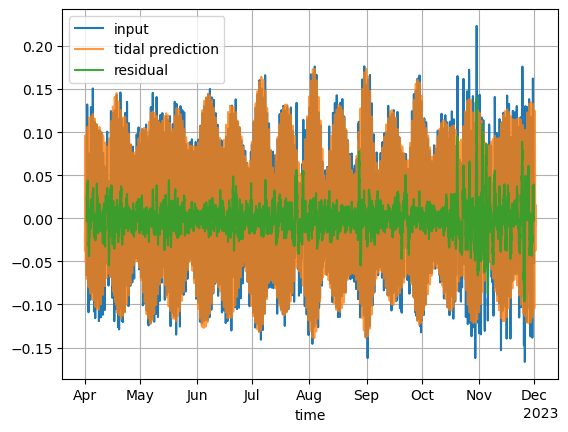

In [53]:
fig, ax = plt.subplots(1,1)
pr["z_in"].plot(label="input")
pr["z_out"].plot(alpha=.8, label="tidal prediction")
(pr["z_in"] - pr["z_out"]).plot(alpha=.9, label="residual")
ax.legend()
ax.grid()

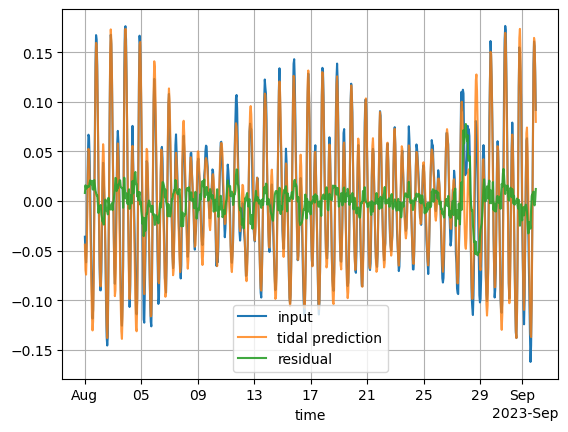

In [54]:
# zoom
_pr = pr.sel(time=slice("2023/08/01", "2023/09/01"))

fig, ax = plt.subplots(1,1)
_pr["z_in"].plot(label="input")
_pr["z_out"].plot(alpha=.8, label="tidal prediction")
(_pr["z_in"] - _pr["z_out"]).plot(alpha=.9, label="residual")
ax.legend()
ax.grid()

---
## compute the harmonic analysis of a reduced time window

In [72]:
tslice = slice("2023/10/25", "2023/11/12")
_ds = ds.sel(time=tslice)

ha_zoom, pr_zoom = solve_and_predict(
    _ds["sea level high"].values, 
    _ds.time.values, 
    float(ds.latitude),
)

solve: matrix prep ... solution ... done.


In [58]:
ha_zoom[["A", "g", "SNR"]].to_dataframe().iloc[:10]

,A,g,SNR,omega_cph,omega_cpd,omega
constituent,,,,,,
M2,0.070105,222.518270,1297.367061,0.080511,1.932274,0.000141
K1,0.035296,162.103725,200.339645,0.041781,1.002738,0.000073
S2,0.030893,215.767225,252.056112,0.083333,2.000000,0.000145
O1,0.016073,112.503275,41.515894,0.038731,0.929536,0.000068
M4,0.006754,4.471440,70.284002,0.161023,3.864547,0.000281
MS4,0.005159,20.517107,41.042111,0.163845,3.932274,0.000286
S4,0.002633,6.721432,10.702892,0.166667,4.000000,0.000291
MSF,0.001372,118.040239,0.861504,0.002822,0.067726,0.000005
M3,0.001179,186.327230,4.071732,0.120767,2.898410,0.000211


<Axes: xlabel='constituent'>

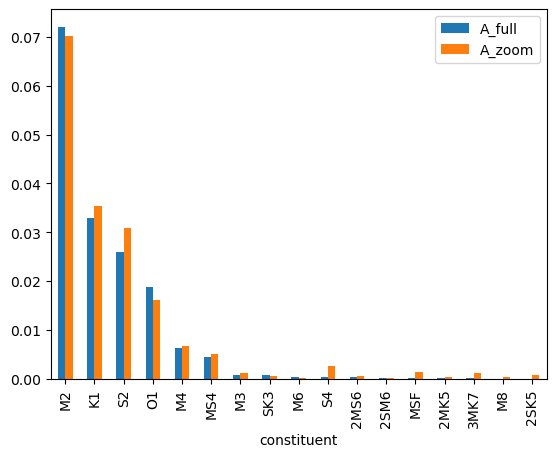

In [69]:
df = pd.merge(
    left=ha[["A", "g", "SNR"]].to_dataframe(), 
    right=ha_zoom[["A", "g", "SNR"]].to_dataframe(),
    on="constituent",
    suffixes=("_full", "_zoom"),
)

df[["A_full", "A_zoom"]].plot.bar()

Inspect time series and compute residual rms

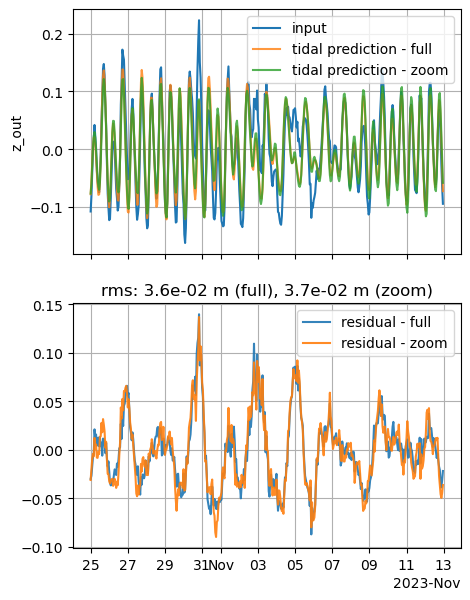

In [87]:
# zoom

_pr = pr.sel(time=tslice)


fig, axes = plt.subplots(2,1, sharex=True, figsize=(5,7))

ax = axes[0]
_pr["z_in"].plot(ax=ax, label="input")
_pr["z_out"].plot(ax=ax, alpha=.8, label="tidal prediction - full")
pr_zoom["z_out"].plot(ax=ax, alpha=.8, label="tidal prediction - zoom")
ax.legend()
ax.grid()
ax.set_xlabel("")

ax = axes[1]
_res_full = (_pr["z_in"] - _pr["z_out"])
_res_full.plot(ax=ax, alpha=.9, label="residual - full")
_res_zoom = (pr_zoom["z_in"] - pr_zoom["z_out"])
_res_zoom.plot(ax=ax, alpha=.9, label="residual - zoom")
ax.legend()
ax.grid()
ax.set_xlabel("")
rms_full = _res_full.std("time")
rms_zoom = _res_zoom.std("time")
ax.set_title(f"rms: {float(rms_full):.1e} m (full), {float(rms_zoom):.1e} m (zoom)");

Weird the rms is larger for the harmonic analysis over the smaller time window, I would have expected the other way around.